## Machine Learning Model Development

##### Import the necessary libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, StratifiedShuffleSplit,\
                                    cross_val_predict
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score,\
                            recall_score, f1_score, roc_auc_score
                            
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.visualization import plot_param_importances

        

import optuna

c:\Users\Administrator\anaconda3\envs\machineind\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###  Some useful Functions

In [23]:
def get_feature_importance(model, model_name):
    """
    Extracts and plots feature importance for a trained model.

    Parameters:
    - model: Trained Pipeline containing the classifier.
    - model_name: Name of the model ('Gradient Boosting' or 'XGBoost').
    """
    # Extract classifier from pipeline
    classifier = model.named_steps['classifier']
    
    # Get feature importance values
    importance = classifier.feature_importances_
    
    # Get transformed feature names from the preprocessor
    preprocessor = model.named_steps['preprocessor']
    
    try:
        feature_names = preprocessor.get_feature_names_out()
    except AttributeError:
        feature_names = X_train.columns  # Fallback if `get_feature_names_out` is not available
    
    # Ensure feature_names and importance lengths match
    if len(importance) != len(feature_names):
        print(f"Warning: Mismatch in feature importance length! ({len(importance)} vs {len(feature_names)})")
        feature_names = [f"Feature {i}" for i in range(len(importance))]  # Assign generic names
    
    # Sort feature importance values
    sorted_idx = np.argsort(importance)[::-1]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(f"{model_name} Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()
    
    # Return feature importance as a dictionary
    return dict(zip(feature_names, importance))

    # Return feature importance as a dictionary
    return dict(zip(feature_names, importance))

In [3]:
def plot_param_importances_(study_model):
    '''
    plot the importance of the most important hyperparameter
    
    study_model: optuna optimized and tuned model
    model: str. The model of interest
    '''
    plotly_config = {"staticPlot": True}
    fig = plot_param_importances(study_model)
    fig.show(config=plotly_config)

In [4]:
# load the dataset
machine = pd.read_csv("../data/machine_downtime_cleaned.csv", parse_dates=['Date'])

# make a copy of the data 
machine_ori = machine.copy()
# print the first few rows
machine.head()

,Date,Machine_ID,Assembly_Line_No,Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Voltage(volts),Torque(Nm),Downtime,Hydraulic_Pressure(Pa),Coolant_Pressure(Pa),Air_System_Pressure(Pa),Cutting(N),Spindle_Speed(RPS)
0,2021-12-08,Makino-L2-Unit1-2015,Shopfloor-L2,4.5,47.9,31.2,1.225,35.214,381.0,23.091903,No_Machine_Failure,14115919.3,513860.1,612765.0,2870.0,253.6
1,2021-12-17,Makino-L2-Unit1-2015,Shopfloor-L2,21.7,47.5,35.8,1.078,29.198,367.0,31.620335,No_Machine_Failure,7246602.0,514111.3,662932.2,2970.0,295.4
2,2021-12-17,Makino-L1-Unit1-2013,Shopfloor-L1,5.2,49.4,34.2,1.266,30.206,340.0,15.900716,Machine_Failure,8828000.0,683941.3,656038.1,2700.0,466.0
3,2021-12-17,Makino-L1-Unit1-2013,Shopfloor-L1,24.4,48.1,36.6,0.778,25.048,307.0,23.923929,Machine_Failure,7454000.0,658019.5,652883.7,3590.0,466.0
4,2021-12-21,Makino-L2-Unit1-2015,Shopfloor-L2,14.1,51.8,32.4,0.969,31.491,380.0,16.964105,Machine_Failure,5326000.0,683941.3,602069.0,2860.0,460.2


### Preprocessing

we have to divide the numeric columns into those that are skewed and those that are normal in order to be able to apply the necessary standardization or normalization to avoid bias

In [5]:
# create an empty list to store columns that are normally or
# skewly distributed
normal_cols = []
skewed_cols = []

# loop through the numerical features
for col in machine_ori.select_dtypes(include=np.number):
    skewness = machine_ori[col].skew()
    kurtosis = machine_ori[col].kurt()

    # set a threshold for kurtosis and skewness and then append the necessary features
    if -0.2 <= skewness <= 0.3 and -0.2 <= kurtosis <= 0.2:  # Adjust thresholds as needed
        normal_cols.append(col)
        print(f"{col}: Skewness = {skewness:.2f}, Kurtosis = {kurtosis:.2f} (Approximately Normal)")
    else:
        skewed_cols.append(col)
        print(f"{col}: Skewness = {skewness:.2f}, Kurtosis = {kurtosis:.2f} (Not Normally Distributed)")


Coolant_Temperature: Skewness = -0.22, Kurtosis = -1.35 (Not Normally Distributed)
Hydraulic_Oil_Temperature: Skewness = -0.00, Kurtosis = 0.05 (Approximately Normal)
Spindle_Bearing_Temperature: Skewness = -0.03, Kurtosis = -0.05 (Approximately Normal)
Spindle_Vibration: Skewness = 0.03, Kurtosis = -0.11 (Approximately Normal)
Tool_Vibration: Skewness = -0.06, Kurtosis = 0.01 (Approximately Normal)
Voltage(volts): Skewness = -0.03, Kurtosis = -0.09 (Approximately Normal)
Torque(Nm): Skewness = 0.03, Kurtosis = -0.46 (Not Normally Distributed)
Hydraulic_Pressure(Pa): Skewness = 0.21, Kurtosis = -0.98 (Not Normally Distributed)
Coolant_Pressure(Pa): Skewness = -0.01, Kurtosis = -0.13 (Approximately Normal)
Air_System_Pressure(Pa): Skewness = -0.05, Kurtosis = 0.01 (Approximately Normal)
Cutting(N): Skewness = 0.12, Kurtosis = -1.09 (Not Normally Distributed)
Spindle_Speed(RPS): Skewness = 0.22, Kurtosis = -0.45 (Not Normally Distributed)


### Model Parameters Preparation

In [6]:
# Define target and features
X = machine_ori.drop(columns=["Downtime", "Date", "Assembly_Line_No"])  # Features

# define encoder
label_encode = LabelEncoder()
y = label_encode.fit_transform(machine_ori["Downtime"])  # Target variable

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
category_col = X.select_dtypes(include=['object']).columns

# Define transformers
preprocessor = ColumnTransformer([
    ("robust", RobustScaler(), skewed_cols),  # Skewed data
    ("standard", StandardScaler(), normal_cols),  # Normal data 
    ('one-hot-encoder', OneHotEncoder(), category_col) # Machine_ID column
])

# Train-test split
# Step 1: Split into Train (60%), Validation (20%), Test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# Define models
models = {
    "Bayesian Logistic Regression": LogisticRegression(solver="lbfgs"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric="auc", random_state = 42)
}


### Train the model 
#### Cross Validation

Since our problem is a classification task, Stratified K-Fold (StratifiedKFold) will be use for the cross validation. 

Why Use Stratified K-Fold?

+ Preserves Class Distribution: Stratified K-Fold ensures that each fold maintains the same proportion of classes as the overall dataset, which is crucial when dealing with classification problems, even if there is no visible class imbalance.
+ More Reliable Performance Estimates: It provides a more stable and representative estimate of your model’s performance compared to ShuffleSplit, which may produce folds with different class distributions.
+ Better Generalization: Ensures that all classes are well represented in training and validation splits, reducing the risk of biased results.

**Key Performance Metrics and Their Meaning**

+ Precision: Measures how many of the predicted failures were actually failures. A high precision means fewer false positives.
+ Recall: Measures how many of the actual failures were correctly identified. A high recall means fewer false negatives.
+ F1-Score: Harmonic mean of precision and recall, balancing both. Higher is better.
+ ROC AUC: Measures the model’s ability to distinguish between classes. A value closer to 1 is better.

In [7]:
# craete an empty list to store model result
model_results = []

# Initialize Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    precision_scores, recall_scores, f1_scores, roc_auc_scores = [], [], [], []

    for train_index, val_index in cv.split(X_train_val, y_train_val):
        X_train_fold, X_val_fold = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]

        # Create a pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Train the model
        pipeline.fit(X_train_fold, y_train_fold)

        # Make predictions
        y_pred = pipeline.predict(X_val_fold)
        y_prob = pipeline.predict_proba(X_val_fold)[:, 1] if hasattr(model, 'predict_proba') else None

        # Evaluate Metrics
        precision_scores.append(precision_score(y_val_fold, y_pred))
        recall_scores.append(recall_score(y_val_fold, y_pred))
        f1_scores.append(f1_score(y_val_fold, y_pred))
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_prob) if y_prob is not None else np.nan)

    # Compute mean scores across folds
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.nanmean(roc_auc_scores)

    # Append results
    model_results.append({
        "Model": name,
        "Precision": round(mean_precision, 4),
        "Recall": round(mean_recall, 4),
        "F1-Score": round(mean_f1, 4),
        "ROC AUC": round(mean_roc_auc, 4)
    })


# Convert results to DataFrame
model_results_df = pd.DataFrame(model_results)

### Model Performance and Best Result

**Model Performance Interpretation**

1. XGBoost (0.9993 ROC AUC, 0.9919 F1-Score)
> + Remains a top performer with exceptional discrimination ability (ROC AUC) and a near-perfect balance of precision and recall (F1-Score).
> + It's likely to generalize well to the test set.

2. Random Forest (0.9990 ROC AUC, 0.9858 F1-Score)
> + Also demonstrates excellent performance, very close to XGBoost.
> + If interpretability is crucial, it might be preferable.

3. Gradient Boosting (0.9991 ROC AUC, 0.9919 F1-Score)
> + Achieves top-tier performance, comparable to XGBoost, with a slight edge in recall.

4. Decision Tree (0.9694 ROC AUC, 0.9692 F1-Score)
> + Shows good performance but falls short compared to the ensemble methods (XGBoost, Random Forest, Gradient Boosting).

5. SVM (0.9439 ROC AUC, 0.8779 F1-Score)
> + Exhibits decent performance but is outperformed by the ensemble models.

6. Bayesian Logistic Regression (0.9292 ROC AUC, 0.8625 F1-Score)
> + Shows moderate performance, lagging behind the other models.

**Observations**
> + Ensemble methods (XGBoost, Random Forest, Gradient Boosting) consistently outperform the single models (Decision Tree, SVM, Bayesian Logistic Regression).
> + XGBoost, Random Forest, and Gradient Boosting have shown remarkable performance, with very high ROC AUC and F1-Scores.

In [8]:
model_results_df.head(10)

,Model,Precision,Recall,F1-Score,ROC AUC
0,Bayesian Logistic Regression,0.8650,0.8607,0.8625,0.9292
1,Random Forest,0.9809,0.9908,0.9858,0.9990
2,Gradient Boosting,0.9889,0.9949,0.9919,0.9991
3,Decision Tree,0.9630,0.9756,0.9692,0.9694
4,SVM,0.8799,0.8760,0.8779,0.9439
5,XGBoost,0.9909,0.9929,0.9919,0.9993


### Hyperparameter Tuning 

In [15]:
# Cross-validation function
def cross_validate_model(model):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores, precision_scores, recall_scores, roc_auc_scores = [], [], [], []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred = pipeline.predict(X_val_fold)
        y_prob = pipeline.predict_proba(X_val_fold)[:, 1] if hasattr(model, 'predict_proba') else None
        
        f1_scores.append(f1_score(y_val_fold, y_pred))
        precision_scores.append(precision_score(y_val_fold, y_pred))
        recall_scores.append(recall_score(y_val_fold, y_pred))
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_prob))
    
    return np.mean([np.mean(f1_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(roc_auc_scores)])

# Define Optuna objective functions for each model
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
       # 'use_label_encoder': False,
        'eval_metric': 'auc'
    }
    return cross_validate_model(xgb.XGBClassifier(**params))


def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }
    return cross_validate_model(GradientBoostingClassifier(**params))



# Run Optuna for each model
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50, timeout=1800)

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=50, timeout=1800)

# Train best models
best_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(**study_gb.best_params, random_state=42))
])
best_gb.fit(X_train, y_train)

best_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(**study_xgb.best_params, random_state=42, eval_metric='auc'))
])
best_xgb.fit(X_train, y_train)



[I 2025-03-02 18:31:07,898] A new study created in memory with name: no-name-17b7ad18-92a0-468a-b311-7264a8edad9d
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3276\4092580619.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2025-03-02 18:31:08,356] Trial 0 finished with value: 0.988278470766415 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.06991102244913713, 'subsample': 0.8037053758657516, 'colsample_bytree': 0.832253805088449, 'gamma': 3.6368572757653874, 'reg_alpha': 8.190019376920393, 'reg_lambda': 3.4901024829099034}. Best is trial 0 with value: 0.988278470766415.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3276\4092580619.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featu

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['Coolant_Temperature',
                                                   'Torque(Nm)',
                                                   'Hydraulic_Pressure(Pa)',
                                                   'Cutting(N)',
                                                   'Spindle_Speed(RPS)']),
                                                 ('standard', StandardScaler(),
                                                  ['Hydraulic_Oil_Temperature',
                                                   'Spindle_Bearing_Temperature',
                                                   'Spindle_Vibration',
                                                   'Tool_Vibration',
                                                   'Voltage(volts)',
                                                   'Coolant_Pressure(Pa)'...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.04664543050831571, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=150,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

#### Get the best parameters for each model

In [16]:
# print the best hyperparameters for the gradient boost
print("Gradient Boost Best params:")
for key, value in study_gb.best_params.items():
    print(f"\t{key}: {value}")

Gradient Boost Best params:
	n_estimators: 300
	learning_rate: 0.18476368934488233
	max_depth: 3
	subsample: 0.8349830456457842


In [17]:
# print the best hyperparameters for the XG Boost
print("XGBoost Best params:")
for key, value in study_xgb.best_params.items():
    print(f"\t{key}: {value}")

XGBoost Best params:
	n_estimators: 150
	max_depth: 8
	learning_rate: 0.04664543050831571
	subsample: 0.7942231875177621
	colsample_bytree: 0.6581279765160521
	gamma: 1.6864430842970046
	reg_alpha: 0.016904277260539224
	reg_lambda: 0.28709776773493223


### Evaluate model on the Test set

#### Interpretation of Test Set Results

1. XGBoost (0.9991 ROC AUC, 0.9816 F1-Score)
+ Maintains excellent performance on the test set, with a very high ROC AUC and F1-Score.
+ This indicates strong generalization ability, meaning it's likely to perform well on new, unseen data.

2. Gradient Boosting (0.9989 ROC AUC, 0.9857 F1-Score)
+ Also shows outstanding performance on the test set, comparable to XGBoost.
+ Achieves a slightly higher F1-Score than XGBoost, indicating a marginally better balance of precision and recall.

3. Random Forest (0.9989 ROC AUC, 0.9837 F1-Score)
+ Performs very well on the test set, with a high ROC AUC and F1-Score.
+ While slightly behind XGBoost and Gradient Boosting, it's still a strong model.

**Observations**

All three models generalize well to the test set, confirming their strong performance observed during training and validation.
Gradient Boosting has a slight edge in F1-Score on the test set, suggesting a better balance of precision and recall compared to XGBoost.
The performance differences between the models are relatively small, indicating that all three are good candidates for deployment.

**Recommendations**

Model Selection:

Our primary focus in selecting a predictive model is maximizing accuracy in identifying potential machine downtime. While computational efficiency and interpretability are valuable,  the ability to proactively prevent downtime is paramount.

In this regard, Gradient Boosting emerged as the top performer, achieving the highest F1-score among the models evaluated. This signifies its superior balance between precision (minimizing false alarms) and recall (capturing the majority of actual downtime events).

Therefore, we will be deploying Gradient Boosting as our predictive model to proactively mitigate machine downtime and enhance operational efficiency.


In [18]:
# Evaluate on test set
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    return {
        'Model': name,
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1-Score': round(f1_score(y_test, y_pred), 4),
        'ROC AUC': round(roc_auc_score(y_test, y_prob) , 4) if y_prob is not None else 'N/A'
    }

results = [
    evaluate_model(best_xgb, 'XGBoost'),
    evaluate_model(best_gb, 'Gradient Boosting')
]

import pandas as pd
results_df = pd.DataFrame(results).sort_values(by=[])
print(results_df)

               Model  Precision  Recall  F1-Score  ROC AUC
0            XGBoost     0.9798  0.9837    0.9817   0.9988
1  Gradient Boosting     0.9918  0.9837    0.9878   0.9991


### Plot Feature Importance After evaluating on test set

#### 1. Key Takeaways from the Plots

**Top Features:**

Both models strongly prioritize Hydraulic Pressure (Pa), Torque (Nm), and Cutting (N) as the most influential factors.
This suggests that variations in these parameters significantly impact machine failures.

**Coolant Pressure and Temperature:**

> Features related to coolant pressure and temperature also have noticeable importance, indicating that overheating or coolant system inefficiencies might lead to failures.

**Spindle Speed and Vibration:**

> Spindle Speed (RPS), Tool Vibration, and Spindle Vibration appear as moderately important features.
> This aligns with the mechanical behavior of precision machining—irregular spindle movement or excessive vibration can indicate wear and tear.
Machine ID Encoding:

> The one-hot encoded Machine_ID features have the lowest importance: This suggests that machine-specific factors are not as crucial as operational parameters (e.g., pressure, torque, cutting force).

##### 2. XGBoost vs. Gradient Boosting Comparison

**XGBoost:**

+ Hydraulic Pressure (Pa) dominates with the highest importance (~0.35).
+ More balanced importance distribution across features.
+ Slightly higher weight for Torque (Nm) and Cutting (N) compared to other features.

**Gradient Boosting:**

+ Hydraulic Pressure (Pa) is even more dominant (~0.42).
+ Less variation in importance among the remaining features, meaning it relies more on a few strong predictors.
+ Coolant Temperature and Vibration features contribute less compared to XGBoost.

#### 3. Summary of the Analysis

> + Hydraulic Pressure (Pa), Torque (Nm), and Cutting (N) are the strongest predictors of machine downtime. If these parameters exceed a threshold, the likelihood of failure increases.
> + Coolant and spindle-related factors play a secondary role, suggesting that temperature regulation and machine stability (vibration) contribute to faults.
> + Machine ID has minimal impact, implying that failures are more dependent on operational conditions than the specific machine being used.

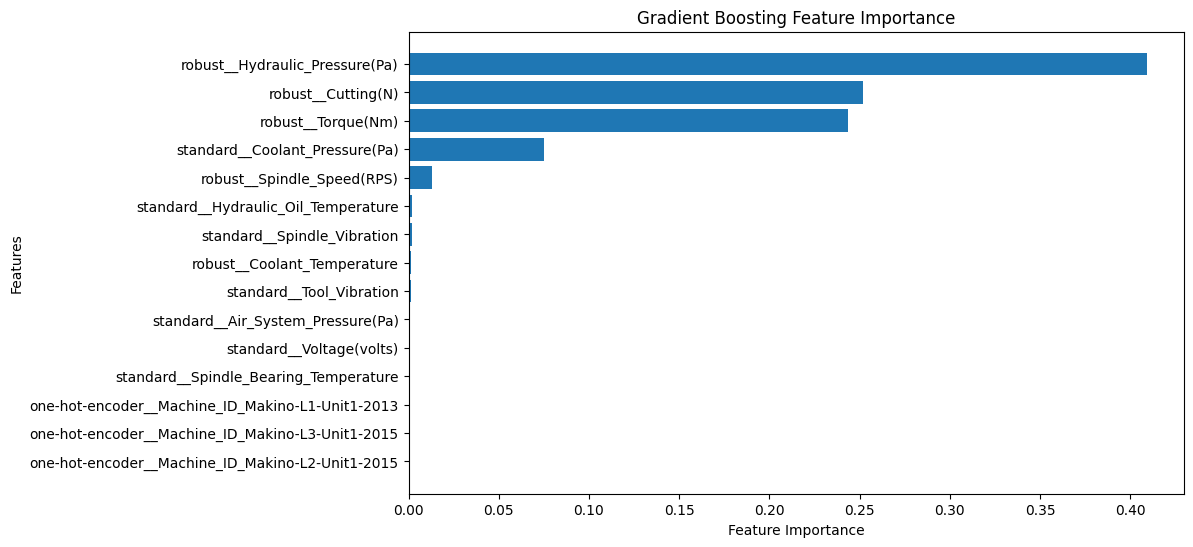

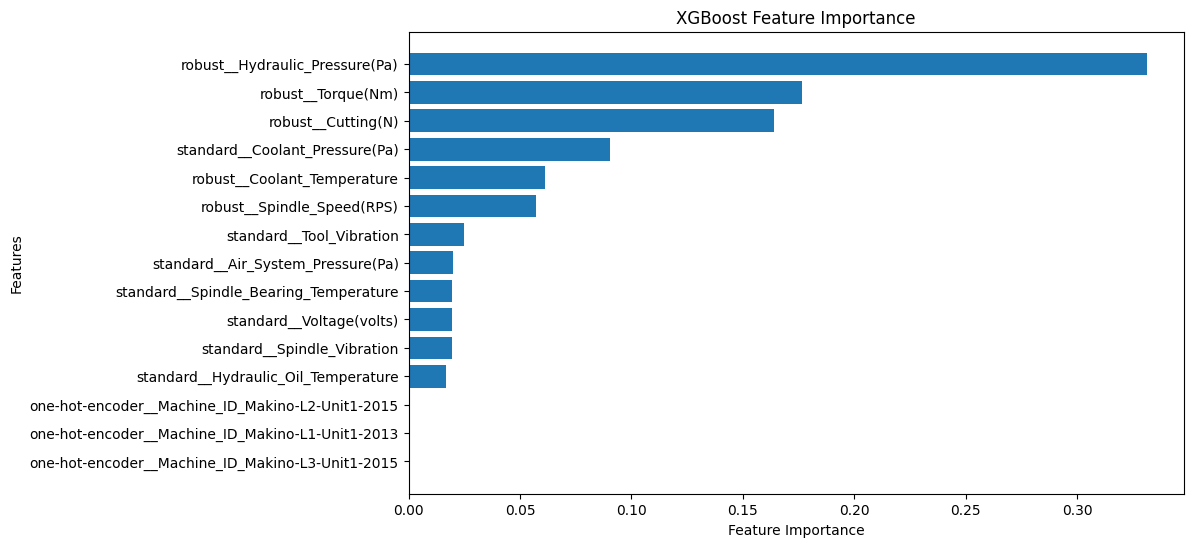

In [24]:
# Get feature importance for the optimized Gradient Boosting model
gb_feature_importance = get_feature_importance(best_gb, "Gradient Boosting")

# Get feature importance for the optimized XGBoost model
xgb_feature_importance = get_feature_importance(best_xgb, "XGBoost")

### Plot Hyperparameter Importance

Visualize how much each hyperparameter contributes to model performance

In [19]:
# plot of Gradient boost most hyperparameter importance
plot_param_importances_(study_gb)


In [20]:
# plot XGBoost  hyperparameter importance
plot_param_importances_(study_xgb)

### Split the Original Data into train and test data and save them as separae csv files for easy implementation of the model pipeline development

In [3]:
# Load the original dataset
machine_ori_split= pd.read_csv("../data/machine_downtime_cleaned.csv", parse_dates=['Date'])

# Define the target variable column
target_column = "Downtime"  # Change to your actual target column

# Split data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(machine_ori_split, test_size=0.2, random_state=42,
                                     shuffle = True, stratify=machine_ori_split[target_column])

# Save the train and test sets as CSV files
train_df.to_csv("../data/train.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)

print("Data successfully split and saved as train.csv and test.csv ✅")

Data successfully split and saved as train.csv and test.csv ✅
